# Do the ETL

In [33]:
import boto3
from bs4 import BeautifulSoup
import pandas as pd
import hashlib

# Read from DB

In [90]:
# from boto3.dynamodb.conditions import Attr
# from datetime import datetime, timedelta
# import time

# dynamodb = boto3.resource('dynamodb')
# table = dynamodb.Table('tpb-top100-ts')

# all_items = []
# response = table.scan()
# all_items.extend(response['Items'])
# while 'LastEvaluatedKey' in response:
#     response = table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
#     all_items.extend(response['Items'])

In [91]:
df = pd.DataFrame(all_items)
df

,uid,data,timestamp
0,1d8db3f8d023683762c4aa3d359caee2,"{'leech': 277, 'uid': '1d8db3f8d023683762c4aa3...",1702512000
1,5d92b7e96fae8d77dfc675f464304633,"{'leech': 73, 'uid': '5d92b7e96fae8d77dfc675f4...",1701720000
2,44bd46650fd64ebb61cad124fe9c02b5,"{'leech': 35, 'uid': '44bd46650fd64ebb61cad124...",1701216000
3,1b92befb430e65e5731b864cbc5eda5e,"{'leech': 90, 'uid': '1b92befb430e65e5731b864c...",1701720000
4,468dfd07de4f7eca754fee1566863b3b,"{'leech': 143, 'uid': '468dfd07de4f7eca754fee1...",1701489600
...,...,...,...
10495,4ae12d5fe4df367a72fa516336d20f0e,"{'leech': 520, 'uid': '4ae12d5fe4df367a72fa516...",1702238400
10496,e4ca6e4c31592a2b7428554c144194d3,"{'leech': 295, 'uid': 'e4ca6e4c31592a2b7428554...",1702267200
10497,1ff7a5ceea087de668517ed965ed991d,"{'leech': 1217, 'uid': '1ff7a5ceea087de668517e...",1702324800
10498,cd01aa666e651b1b1d8839cdeef91770,"{'leech': 212, 'uid': 'cd01aa666e651b1b1d8839c...",1701921600


In [92]:
df_analysis = pd.DataFrame.from_records(df['data']).sort_values(['timestamp', 'seed'], ascending=False)

df_analysis

,leech,uid,torrent_url,type_b,type_a,seed,megabytes,uploaded,title,icons,user,timestamp
1944,920,951a1f190261b83a5ff61d0756feccb2,https://thepiratebay.org/description.php?id=73...,HD Movies,Video,983,2068,2023-11-08,Oppenheimer.2023.1080p.BluRay.DD5.1.x264-GalaxyRG,"[icon-magnet, vip]",GalaxyRG,1702512000
3338,31,df9b95d8daf3aa4c9a3d606497859745,https://thepiratebay.org/description.php?id=53...,E-books,Other,944,6,2021-11-05,Python Programming And Maching Learning Unders...,"[icon-magnet, trusted.png]",CJDanVamme,1702512000
1840,1753,6afd63daa8c4a00c9549bf2900e0fdb4,https://thepiratebay.org/description.php?id=74...,HD Movies,Video,764,1638,2023-12-08,Leave.the.World.Behind.2023.1080p.NF.WEBRip.16...,"[icon-magnet, vip]",GalaxyRG,1702512000
5610,484,1ef665aa382575c9d6c965ef9ae812b5,https://thepiratebay.org/description.php?id=73...,HD TV-Shows,Video,674,1372,2023-11-27,Rick.and.Morty.S07E07.1080p.WEB.H264-Industrio...,"[icon-magnet, vip]",TGxGoodies,1702512000
7434,441,fc6d61eaabd03e592dc42043dc1ccd08,https://thepiratebay.org/description.php?id=73...,HD TV-Shows,Video,617,1361,2023-11-20,Rick.and.Morty.S07E06.1080p.WEB.H264-NHTFS[TGx],"[icon-magnet, vip]",TGxGoodies,1702512000
...,...,...,...,...,...,...,...,...,...,...,...,...
8421,477,eca56620fbfeaa5e0f65ccaae7257dbb,https://thepiratebay.org/description.php?id=32...,HD TV-Shows,Video,51,42076,2019-05-17,The.Big.Bang.Theory.2007.COMPLETE.SERIES.720p....,"[icon-magnet, vip]",sotnikam,1701014400
3624,368,c20fdda30f393fd750fe7394b687e21d,https://thepiratebay.org/description.php?id=36...,HD TV-Shows,Video,49,114155,2020-10-01,Game.of.Thrones.Season.1-8.S01-08.COMPLETE.108...,"[icon-magnet, vip]",Cybotage,1701014400
2535,587,f41d250fd26a4f687c15bc9ea616a777,https://thepiratebay.org/description.php?id=36...,HD TV-Shows,Video,28,173537,2020-09-30,Friends (1994) Season 1-10 S01-S10 (1080p BluR...,"[icon-magnet, vip]",Cybotage,1701014400
7496,441,deec147c50dab1c350d4ca1f4206eb81,https://thepiratebay.org/description.php?id=36...,HD TV-Shows,Video,28,99307,2020-10-01,How I Met Your Mother (2005) Season 1-9 S01-S0...,"[icon-magnet, vip]",Cybotage,1701014400


In [93]:
df_analysis['timestamp'] = pd.to_datetime(
	df_analysis.timestamp.astype(int), unit='s'
)

In [105]:
df_analysis = df_analysis.query("timestamp > '2023-12-08 18:00'").copy()

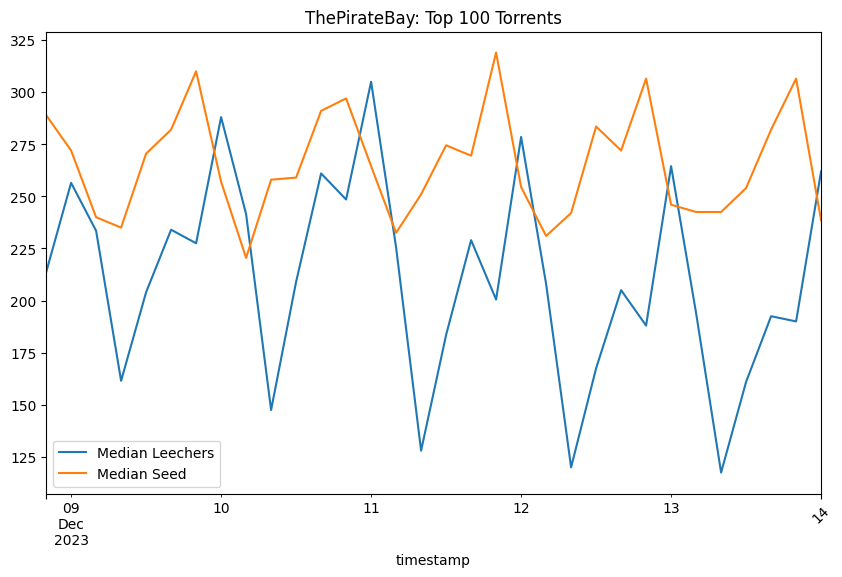

In [106]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10,6))
df_analysis.groupby('timestamp').leech.median().plot(label='Median Leechers')
df_analysis.groupby('timestamp').seed.median().plot(label='Median Seed')

plt.legend(loc='best')
plt.title('ThePirateBay: Top 100 Torrents')

ax = plt.gca()

plt.xticks(rotation=45)  # rotating xticks for better visibility
plt.show()



In [108]:
df_analysis.head()

,leech,uid,torrent_url,type_b,type_a,seed,megabytes,uploaded,title,icons,user,timestamp
1944,920,951a1f190261b83a5ff61d0756feccb2,https://thepiratebay.org/description.php?id=73...,HD Movies,Video,983,2068,2023-11-08,Oppenheimer.2023.1080p.BluRay.DD5.1.x264-GalaxyRG,"[icon-magnet, vip]",GalaxyRG,2023-12-14
3338,31,df9b95d8daf3aa4c9a3d606497859745,https://thepiratebay.org/description.php?id=53...,E-books,Other,944,6,2021-11-05,Python Programming And Maching Learning Unders...,"[icon-magnet, trusted.png]",CJDanVamme,2023-12-14
1840,1753,6afd63daa8c4a00c9549bf2900e0fdb4,https://thepiratebay.org/description.php?id=74...,HD Movies,Video,764,1638,2023-12-08,Leave.the.World.Behind.2023.1080p.NF.WEBRip.16...,"[icon-magnet, vip]",GalaxyRG,2023-12-14
5610,484,1ef665aa382575c9d6c965ef9ae812b5,https://thepiratebay.org/description.php?id=73...,HD TV-Shows,Video,674,1372,2023-11-27,Rick.and.Morty.S07E07.1080p.WEB.H264-Industrio...,"[icon-magnet, vip]",TGxGoodies,2023-12-14
7434,441,fc6d61eaabd03e592dc42043dc1ccd08,https://thepiratebay.org/description.php?id=73...,HD TV-Shows,Video,617,1361,2023-11-20,Rick.and.Morty.S07E06.1080p.WEB.H264-NHTFS[TGx],"[icon-magnet, vip]",TGxGoodies,2023-12-14
